In [1]:
pip show qiskit | grep Version

Version: 0.46.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append("../src")

In [4]:
import utils
import qiskit
import numpy as np
import qiskit_aer
from bitstring import BitArray

In [52]:
data = np.array([0., -0.25, 0.5 , 0.75,  -0.75  ,  -1.,  0.25 ,  0.]) #utils.simulate_data(num_samples=8)
time_resolution = int(np.log2(len(data)))

In [ ]:
angles = utils.convert_to_angles(data)

In [ ]:
time_register      = qiskit.QuantumRegister(time_resolution,'t')
amplitude_register = qiskit.QuantumRegister(1,'a')
qc = qiskit.QuantumCircuit(amplitude_register,time_register)
qc.h(time_register)

In [ ]:
def apply_x(qc,t,treg):
    t_bitstring = []
    for i, treg_qubit in enumerate(treg):
        t_bit = (t >> i) & 1
        t_bitstring.append(t_bit)
        if not t_bit:
            qc.x(treg_qubit)

In [ ]:
def value_setting(qc, t, a, treg, areg):
    apply_x(qc, t, treg)
    mc_ry = qiskit.QuantumCircuit()
    mc_ry.add_register(areg)
    mc_ry.ry(2*a, 0)
    mc_ry = mc_ry.control(treg.size)
    qc.append(mc_ry, [i for i in range(treg.size + areg.size - 1, -1, -1)])
    apply_x(qc, t, treg)

In [ ]:
for t, theta in enumerate(angles):        
    value_setting(qc, t, theta, time_register, amplitude_register)

In [ ]:
qc.draw('mpl',style='clifford')

In [66]:
def measure(qc, treg_pos = 1, areg_pos = 0):
    treg = qc.qregs[treg_pos]
    areg = qc.qregs[areg_pos]
       
    ctreg = qiskit.ClassicalRegister(treg.size, 'ct')
    careg = qiskit.ClassicalRegister(areg.size, 'ca')        
    qc.add_register(careg)
    qc.add_register(ctreg)
        
    qc.measure(treg, ctreg)
    qc.measure(areg, careg)

In [ ]:
measure(qc)

In [ ]:
qc.draw('mpl',style='clifford')

In [69]:
backend = qiskit_aer.AerSimulator()
shots = 1024

In [ ]:
job = qiskit.execute(qc,backend=backend,shots=1024)
counts = job.result().get_counts()

In [ ]:
def reconstruct(treg_size, counts, shots=1024):
    N = 2**treg_size
    cosine_amps = np.zeros(N)
    sine_amps = np.zeros(N)
    for state in counts:
        (t_bits, a_bit) = state.split()
        t = int(t_bits, 2)
        a = counts[state]
        if (a_bit == '0'):
            cosine_amps[t] = a
        elif (a_bit =='1'):
            sine_amps[t] = a
    return 2*(sine_amps/(cosine_amps+sine_amps))-1

In [ ]:
utils.plot(data)

In [ ]:
utils.plot(reconstruct(8,counts))

In [53]:
def treg_index_X(qc, t, treg):
    t_bitstring = []
    for i, treg_qubit in enumerate(treg):
        t_bit = (t >> i) & 1
        t_bitstring.append(t_bit)
        if not t_bit:
            qc.x(treg_qubit)

In [62]:
def omega_t(qc, t, a, treg, areg):
    treg_index_X(qc, t, treg)
    astr = []
    for i, areg_qubit in enumerate(areg):
        a_bit = (a >> i) & 1
        astr.append(a_bit)
        if a_bit:
            qc.mct(treg, areg_qubit)
    treg_index_X(qc, t,treg)

In [63]:
def encode(audio, time_resolution, bit_depth):
    audio = audio*(2**(bit_depth-1))
    time_register      = qiskit.QuantumRegister(time_resolution,'t')
    amplitude_register = qiskit.QuantumRegister(bit_depth,'a')
    qc = qiskit.QuantumCircuit(amplitude_register,time_register)
    qc.h(time_register)
    for t, sample in enumerate(audio):
        omega_t(qc, t, int(sample), time_register, amplitude_register)
    return qc

In [64]:
qc = encode(data,3,3)

/var/folders/lq/shl3t2n51mgdksn52y8zz7t00000gn/T/ipykernel_1242/504158835.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(treg, areg_qubit)


In [67]:
measure(qc)

In [70]:
#qc.draw('mpl')

In [71]:
job = qiskit.execute(qc,backend=backend,shots=1024)
counts = job.result().get_counts()

/var/folders/lq/shl3t2n51mgdksn52y8zz7t00000gn/T/ipykernel_1242/2088830272.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = qiskit.execute(qc,backend=backend,shots=1024)


In [72]:
def decode(treg_size, counts):
    N = 2**treg_size
    audio = np.zeros(N, int)
    
    for state in counts:
        (t_bits, a_bits) = state.split()
        t = int(t_bits, 2)
        # The BitArray function converts binary words into signed integers,
        # in oposition to the int(a_bit, 2) function.
        a = BitArray(bin=a_bits).int
        audio[t] = a

    return audio

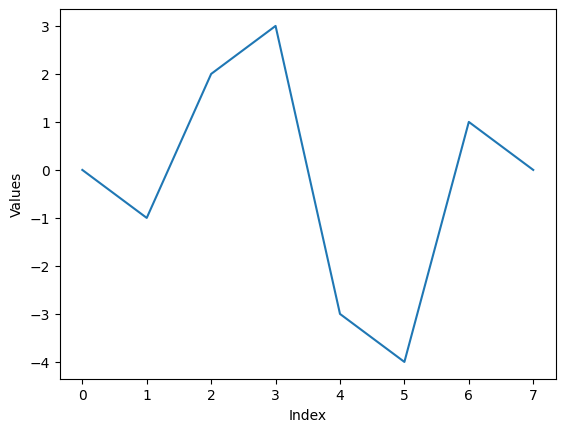

In [75]:
utils.plot(decode(time_resolution,counts))